In [1]:
import neurons
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import random
%matplotlib inline
import xlsxwriter
from scipy import stats
import pandas as pd
from sklearn.metrics import mean_squared_error
import statistics as st

In [2]:
def dimensionality(x,N=500):
    x1_latetime=x[:,25:] #cuts of beginning
    covariance = (1/N-1)*np.matmul (x1_latetime,x1_latetime.T)
    #eig_value = np.linalg.eigvals(covariance)
    eig_value, eig_vec = np.linalg.eigh(covariance)
    #eig_subset = eig_value[:100]
    eig_subset = eig_value
    eig_subset_sqrd=eig_subset**2
    dim=eig_subset.sum()**2/eig_subset_sqrd.sum()
    #print(dim)
    return dim

In [9]:
#network (bi-directionality and learning can be commented in/out)
#K=2
my_resuls = {}
dimen={}
def runsim(N=500):
    g = 2
    T = 100
    dt = 0.1
    bi=7
    alpha = 1
    f = 0.5
    W = np.zeros(N)
    W_fb = np.random.randn(N)
    stoplearn = T/2 #when to stop learning

    phi = np.tanh

    NT = int(T/dt)
    tx = dt*np.arange(NT)
    x = np.zeros([N,NT])
    z = np.zeros(NT) 
    err = np.zeros(NT) 
        #random initial conditions
    x[:,0] = 0.1*np.random.standard_normal(N)          #0.1?
    P = np.eye(N)/alpha

#SPARSITY
    #mask = np.zeros([N,N])
    #for row in range(N):
        #columns=random.sample(range(N),K)
        #for column in columns:
            #mask[row,column]=1
    #list(mask)
    #J = g/np.sqrt(K) * np.random.standard_normal([N,N]) 
    #J_sparse = np.multiply(J, mask)

#BI-DIRECTIONAL SPARSITY
    mask = np.zeros([N,N])
    for row in range(N):
        columns=random.sample(range(N),bi)
        for column in columns:
            mask[row,column]=1
            mask[column,row]=1
    for row in range(N):
        columns=random.sample(range(N),K)
        for column in columns:
            mask[row,column]=1
    list(mask)
    J = g/np.sqrt(K) * np.random.standard_normal([N,N]) 
    J_sparse = np.multiply(J, mask) 
    
    
    omega = 2*pi*f
    target = np.sin(omega*tx) #target sine wave
    ind_stoplearn = int(stoplearn/dt)

#SIMULATION
    for ti in range(NT-1): 

        x1 = x[:,ti]
        z[ti] = np.dot(W,x1) 
        err[ti] = z[ti] - target[ti]

        dx = -x[:,ti] + phi(J_sparse @ x[:,ti] + W_fb*z[ti])

        x[:,ti+1] = x[:,ti] + dt*dx 


#LEARNING
        if ti < ind_stoplearn:
            #weight update
            W = W - err[ti]*P@x1
            #RLS update
            P = P - (P @ np.outer(x1,x1) @ P)/(1 + x1.T @ P @ x1)
#Error            
    my_resuls[K] = mean_squared_error(z, target)
    dimen[K]=dimensionality(x,N=100)
    return x, tx, my_resuls[K]





In [4]:
phi = np.tanh
def calc_autocorr(x):
    N = x.shape[0]
    NT = x.shape[1]
    C = np.zeros(NT)
    for tau in range(NT): 
        acc = np.zeros(N)
        for ti in range(NT-tau): 
            acc += phi(x[:,ti]) * phi(x[:,ti+tau])
        acc /= NT-tau 
        C[tau] = acc.sum()/N 
    C /= C[0] #scales to 1
    return C

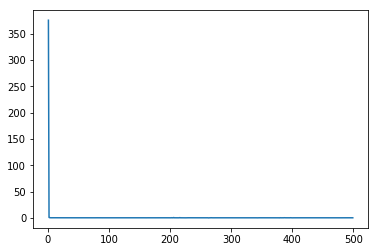

In [11]:
#Error and sparsity
my_resuls = {}
for K in range(1,500):
    runsim()
pd.Series(my_resuls).plot()


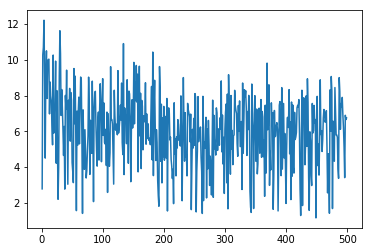

In [12]:
#Dimen and Sparsity
pd.Series(dimen).plot()

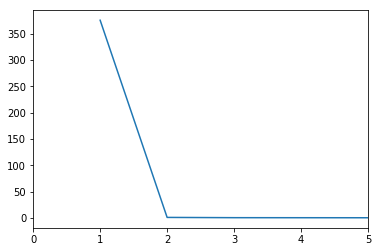

In [13]:
pd.Series(my_resuls).plot(xlim=(0,5))

In [15]:
#Average Dimensionality and error for 100 runs
K=2
dims=np.zeros(100)
errors=np.zeros(100)
for runs in range(1,100):
    x,tx,error=runsim()
    dim=dimensionality(x)
    dims[runs]=dim
    errors[runs]=error
avg_error=np.mean(errors)
avg_dim=np.mean(dims)
print(avg_dim)
print(avg_error)

5.337336995529612
66.60475919922929


In [ ]:
#Runsim and autocorrolation(the autocor takes a long time)
x, tx, error=runsim()
C_g1=calc_autocorr(x)

In [ ]:
#Plot 5 sample neurons and autocorrolation
fig = plt.figure(figsize=[5.,2.])

ax = plt.subplot(121) 
plt.plot(tx, x[0:5].T)
plt.ylim(-1,1)
plt.xticks((0,50,100))
plt.yticks((-1,0,1))
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('g=_ & K=_')

ax = plt.subplot(122)
plt.plot(tx, C_g1) 
plt.ylim(-1,1)
plt.xticks((0,50,100))
plt.yticks((-1,0,1)) 
plt.xlabel('Tau')
plt.ylabel('C')
plt.tight_layout()
plt.title('autocorr')


In [ ]:
#HISTOGRAMS - the runsim in the "neurons" file doesn't have learning or bi-directionality
run1_args = {'g':2,'K':800}
tx1,x1,J1 = neurons.runsim(**run1_args)
#permutate values to make all the histograms
runs=[{}]
runs = neurons.perm_over(runs,'g',[0.9,2,5])
runs = neurons.perm_over(runs,'K',[2,10,100])
print(runs)
size=(len(runs))
results=[]
for run in runs:
    results.append(neurons.runsim(**run)) #actual run

#making histograms    
means=[]
stds=[]

def node_histogram (x, J, N=800, T=100, dt=.1, K=100, **kwargs):
    NT = int(T/dt)
    neuron = np.zeros([N,NT])
    single_neurons=np.zeros([N,NT])

    for ti in range(NT):   
        neuron[:,ti] =  J@(x[:,ti])
        
    avg_neuron=neuron.mean(axis=0)
    
    plt.hist(avg_neuron, 40)
    plt.xticks((-0.2,0,0.2))
    plt.show()
    mean=np.mean(avg_neuron)
    std=np.std(avg_neuron)
    
    means.append(mean)
    stds.append(std)  
    
    
    #PLOTS SINGLE NETWORK AS AN AVERAGE OF NEURONS 
    single_neuron=neuron[0,:] #first row, all columns
    return (mean, std,)
 
    #PLOTS SINGLE NETWORK AS AN AVERAGE OF NEURONS AND ALSO SINGLE NEURONS OF EACH 
    #single_neurons=neuron[:,:] 
    #for row in range(10): #range is amount of single neuron examples
        #plt.hist(single_neurons[row,:], 40)
        #plt.xticks((-0.2,0,0.2))
        #plt.show()
        #print(node_histogram(result['x'],result['J'],**run))
        #return (mean, std)

In [ ]:
#PLOT HISTOGRAMS
# first histogram would be: node_histogram(results[0]['x'],results[0]['J'],**runs[0])

means=[]
stds=[]
label=[]
for result, run in zip(results,runs):
    print(run)
    label.append(run)
    print(node_histogram(result['x'],result['J'],**run))
    

In [ ]:
#Thank you for everything! :) 